In [1]:
import os
import pandas as pd

In [2]:
from numpy.random import normal

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
os.chdir(os.path.join(os.getcwd(),'../../..'))
import ExMAS.main
import ExMAS.utils
from ExMAS.transitize import *

In [5]:
import seaborn as sns

In [6]:
from ExMAS.transitize.main import stick_private_to_ms

In [7]:
import json
from ExMAS.utils import *

In [8]:
from ExMAS.transitize import visualizations
from ExMAS.transitize import analysis

In [9]:
plt.style.use(['science', 'no-latex'])
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

In [10]:
params = ExMAS.utils.get_config('ExMAS/data/configs/transit.json')  # load the default

In [11]:
inData = analysis.load_results(PATH ='transit_results/pol_godziny', EXP_NAME = 'pol_godziny')

In [12]:
inData.transitize.requests = analysis.PT_utility(inData.transitize.requests, params)

In [13]:
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [14]:
inData.skims = DotMap(_dynamic=False)  # skim matrices of the network
inData.skims.dist = inData.skim.copy()  # distance (meters)
inData.skims.ride = inData.skims.dist.divide(params.speeds.ride).astype(int).T  # travel time (seconds)
inData.skims.walk = inData.skims.dist.divide(params.speeds.walk).astype(int).T  # walking time (seconds)

In [15]:
from ExMAS.main import init_log
params.logger_level = 'WARNING'
inData.logger = init_log(params)

In [17]:
#inData = stick_private_to_ms(inData, params)

In [18]:
#r = inData.transitize.requests
#r[r.ride_solution_4 != r.ride_solution_3]

In [23]:
inData = analysis.make_report(inData)
inData.transitize.report

,0,1,2,3
d2d,NaN,1.345000e+03,1.184000e+03,1.065000e+03
dest_walk_time,0.000000,0.000000e+00,3.914700e+04,6.774600e+04
fare,11848.803000,9.102147e+03,8.702988e+03,8.053174e+03
ms,NaN,NaN,NaN,2.250000e+02
nRides,2000.000000,1.597020e+05,1.602390e+05,1.009855e+06
orig_walk_time,0.000000,0.000000e+00,4.272800e+04,7.213400e+04
p,2000.000000,6.550000e+02,6.450000e+02,6.510000e+02
s2s,NaN,NaN,1.710000e+02,5.900000e+01
test,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
ttrav,986517.000000,1.304161e+06,1.217569e+06,1.051354e+06


In [24]:
report = inData.transitize.report
report.columns = ['private','door-to-door pooled','stop-to-stop pooled','hyper-pooled']
compos = report.loc[['p','d2d','s2s','ms','nRides']].fillna(0).astype(int).T
compos.columns = ['private','door-to-door pooled','stop-to-stop pooled','hyper-pooled','$\#$rides']
compos.index.name = 'solution'
compos.style.set_caption("Rides composition")

,private,door-to-door pooled,stop-to-stop pooled,hyper-pooled,$\#$rides
solution,,,,,
private,2000,0,0,0,2000
door-to-door pooled,655,1345,0,0,159702
stop-to-stop pooled,645,1184,171,0,160239
hyper-pooled,651,1065,59,225,1009855


In [25]:
print(compos.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  private &  door-to-door pooled &  stop-to-stop pooled &  hyper-pooled &  \$\textbackslash \#\$rides \\
solution            &          &                      &                      &               &            \\
\midrule
private             &     2000 &                    0 &                    0 &             0 &       2000 \\
door-to-door pooled &      655 &                 1345 &                    0 &             0 &     159702 \\
stop-to-stop pooled &      645 &                 1184 &                  171 &             0 &     160239 \\
hyper-pooled        &      651 &                 1065 &                   59 &           225 &    1009855 \\
\bottomrule
\end{tabular}



In [27]:
rm = inData.transitize.rm
ms = rm[(rm.kind=='ms') & (rm.solution_3==1)]
ms

,ride,traveller,degree,dist,ttrav,delay,u,orig_walk_time,dest_walk_time,VoT,...,destination,treq,kind,s2s_reference,door_departure,fare,solution_0,solution_1,solution_2,solution_3
1477,160260,1477,4.0,6102,687.0,187.5,6.533073,274.0,199.0,0.002876,...,1578757568,1394,ms,160142.0,1581.5,2.288250,0,0,0,1
1776,160260,1776,4.0,6117,687.0,145.5,7.584394,66.0,373.0,0.003815,...,46322001,1644,ms,160142.0,1789.5,2.293875,0,0,0,1
1623,160260,1623,4.0,7548,846.0,523.5,12.445932,450.0,368.0,0.003941,...,46179537,1542,ms,160161.0,2065.5,2.830500,0,0,0,1
1970,160260,1970,4.0,6331,846.0,388.5,11.923214,298.0,0.0,0.005484,...,46178576,1829,ms,160161.0,2217.5,2.374125,0,0,0,1
234,161743,234,4.0,6380,665.0,506.0,10.207418,404.0,415.0,0.003523,...,7602202566,255,ms,159983.0,761.0,2.392500,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,785769,455,10.0,4115,576.0,574.0,9.228761,233.0,350.0,0.003893,...,46338006,395,ms,159760.0,969.0,1.543125,0,0,0,1
480,785769,480,10.0,9488,1424.0,131.0,12.283304,393.0,151.0,0.003821,...,46201004,403,ms,159775.0,534.0,3.558000,0,0,0,1
388,785769,388,10.0,10578,1424.0,129.0,11.258697,426.0,194.0,0.003094,...,46205852,372,ms,159775.0,501.0,3.966750,0,0,0,1
546,785769,546,10.0,8123,1106.0,272.0,10.461803,308.0,280.0,0.003427,...,46283291,434,ms,159782.0,706.0,3.046125,0,0,0,1


In [74]:
19/75

0.25333333333333335

In [75]:
0.52/2.1

0.24761904761904763

In [72]:
nP = 2000
from math import comb, factorial
c=comb(2000,14)
c = c*factorial(14)*factorial(14)
"{:e}".format(c)rop-offf

('1.364656e+57', '1.795588e+35')

In [28]:
pd.set_option('display.precision', 2)
report = report.T
report['walk_time'] = report['orig_walk_time']+report['dest_walk_time']
report = report.T

KPIs = report.loc[['u_veh','u_pax','ttrav','walk_time','nRides', 'fare', 'efficiency','occupancy']].fillna(0).T
for col in ['u_veh','ttrav', 'walk_time']:
    KPIs[col] = (KPIs[col]/3600).round(2)
for col in ['u_pax','nRides', 'fare']:
    KPIs[col] = KPIs[col].astype(int)
for col in ['efficiency','occupancy']:
    KPIs[col] = KPIs[col].round(2)
KPIs.u_veh = KPIs.u_veh
KPIs.columns = ['vehicle hours','travellers costs (utility)','passenger in-vehicle hours',
                'walk time ', 'feasible rides', 'total fare', 
                'fares per veh hours', 'occupancy']

KPIs.index.name = 'solution'
KPIs.style.set_caption("KPIs")

,vehicle hours,travellers costs (utility),passenger in-vehicle hours,walk time,feasible rides,total fare,fares per veh hours,occupancy
solution,,,,,,,,
private,274.030000,15289,274.030000,0.000000,2000,11848,43.240000,1.000000
door-to-door pooled,179.120000,14635,362.270000,0.000000,159702,9102,50.810000,1.530000
stop-to-stop pooled,176.080000,14376,338.210000,22.740000,160239,8702,49.430000,1.560000
hyper-pooled,171.220000,13298,292.040000,38.860000,1009855,8053,47.030000,1.600000


In [29]:
KPIs[KPIs.columns[1]] = -KPIs[KPIs.columns[1]]

In [30]:
print(KPIs.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  vehicle hours &  travellers costs (utility) &  passenger in-vehicle hours &  walk time  &  feasible rides &  total fare &  fares per veh hours &  occupancy \\
solution            &                &                             &                             &             &                 &             &                      &            \\
\midrule
private             &         274.03 &                      -15289 &                      274.03 &        0.00 &            2000 &       11848 &                43.24 &       1.00 \\
door-to-door pooled &         179.12 &                      -14635 &                      362.27 &        0.00 &          159702 &        9102 &                50.81 &       1.53 \\
stop-to-stop pooled &         176.08 &                      -14376 &                      338.21 &       22.74 &          160239 &        8702 &                49.43 &       1.56 \\
hyper-pooled        &         171.22 &                      -1

In [16]:
inData.transitize.rm['selected'] = inData.transitize.rm[['solution_0','solution_1','solution_2','solution_3']].max(axis=1)

In [17]:
requests = inData.transitize.requests
rm = inData.transitize.rm[inData.transitize.rm.selected==1]

In [18]:
ttrav_ms = rm[rm.kind=='ms'].ttrav.sum()
ttrav_p = rm[(rm.kind=='p') & (rm.traveller.isin(rm[rm.kind=='ms'].traveller))].ttrav.sum()
u_veh = inData.transitize.rides[(inData.transitize.rides.solution_3==1) &(inData.transitize.rides.kind=='ms')].u_veh.sum()

In [20]:
requests['fare_3'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_3) & (rm.traveller == x.name)].fare.max(), axis = 1)
requests['fare_2'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_2) & (rm.traveller == x.name)].fare.max(), axis = 1)
requests['u_3'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_3) & (rm.traveller == x.name)].u.max(), axis = 1)
requests['u_2'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_2) & (rm.traveller == x.name)].u.max(), axis = 1)
requests['u_1'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_1) & (rm.traveller == x.name)].u.max(), axis = 1)
requests['u_0'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_1) & (rm.traveller == x.name)].u.max(), axis = 1)

In [21]:
d = dict()
d['p'] = 'private'
d['s2s'] = 'stop-to-stop'
d['d2d'] = 'door-to-door'
d['ms']= 'hyper-pooled'
inData.transitize.rides['kind_2'] = inData.transitize.rides['kind'].apply(lambda x: d[x])

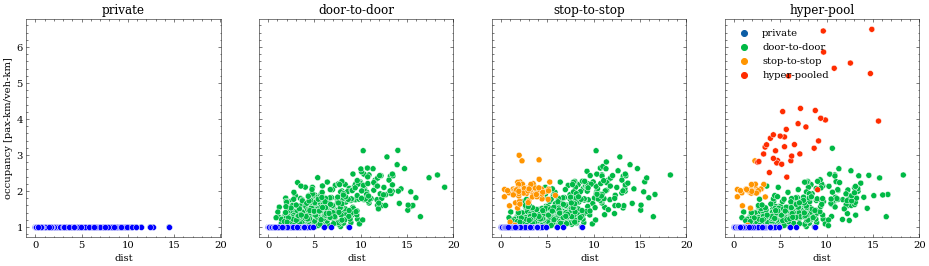

In [29]:
fig, ax = plt.subplots(1,4, figsize = (16,4), sharey = True, sharex= True)
ax = ax.flatten()
Y = 'occupancy [pax-km/veh-km]'
titles = ['private','door-to-door','stop-to-stop','hyper-pool']
for level in [0,1,2,3]:
    solution = inData.transitize.rides[inData.transitize.rides['solution_{}'.format(level)] ==1]
    solution['ttrav_total'] = solution.apply(lambda x: inData.transitize.rm[inData.transitize.rm.ride == x.name].ttrav.sum(),axis = 1)
    solution[Y] = solution['ttrav_total'] / solution['u_veh']
    solution['dist'] = solution.u_veh/1000*params.avg_speed
    sns.scatterplot(data = solution, x = 'dist', y = Y, hue = 'kind_2' , 
                    ax = ax[level])
    sns.scatterplot(data = solution[solution.kind_2 == 'private'], x = 'dist', y = Y,
                    ax = ax[level], color = 'blue')
    ax[level].set_title(titles[level])
    if level != 3:
        ax[level].get_legend().remove()
plt.savefig('occupancy.png',dpi = 300)

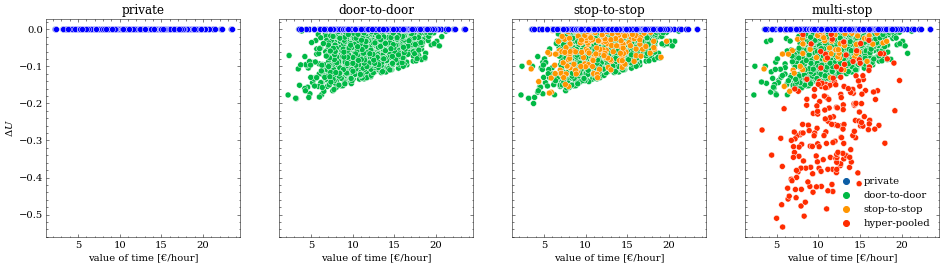

In [27]:
X = 'value of time [€/hour]'
rm = inData.transitize.rm[inData.transitize.rm.selected>0]
rm[X] = rm.VoT*3600
rm['kind_2'] = rm['kind'].apply(lambda x: d[x])
fig, ax = plt.subplots(1,4, figsize = (16,4), sharey = True, sharex = True)
ax = ax.flatten()
titles = ['private','door-to-door','stop-to-stop','multi-stop']
for level in [0,1,2,3]:

    solution = rm[rm['solution_{}'.format(level)] ==1].copy()
    #solution[solution.kind == 'ms'].u = solution[solution.kind == 'ms'].apply(lambda x: utility_s2s(x), axis =1) 
    solution['u_private'] = solution.apply(lambda x: rm[(rm.kind=='p')& (rm.traveller == x.traveller)].u.max(), axis =1)
    solution['$\Delta U$'] = np.minimum(0,(solution.u - solution.u_private ) / solution.u_private)
    sns.scatterplot(data = solution, x = X, y = '$\Delta U$', hue = 'kind_2' , 
                    ax = ax[level])
    sns.scatterplot(data = solution[solution.kind_2 == 'private'], x = X, y = '$\Delta U$',
                    ax = ax[level], color = 'blue')
    
    ax[level].set_title(titles[level])
    if level <3:
        ax[level].get_legend().remove()
#plt.savefig('VoT.png',dpi = 300)


In [43]:
x = [0,214]
x[1:-1]

[]

In [44]:
level = 3
solution = inData.transitize.rides[inData.transitize.rides['solution_{}'.format(level)] ==1]
solution['ttrav'] = solution.times.apply(lambda x: sum(x[1:-1]) if len(x)>2 else x[-1])

,level_0,index,indexes,indexes_orig,indexes_dest,u_pax,u_veh,kind,ttrav,times,...,dest_walk_time,low_level_indexes_set,origin,destination,d2d_reference,solution_2,high_level_indexes,solution_3,fare,kind_2
0,0,0.0,[0],[0],[0],3.670524,214.000,p,214.000,"[0, 214]",...,NaN,NaN,NaN,NaN,NaN,1,NaN,1,2.575500,private
1,1,1.0,[1],[1],[1],0.324875,21.000,p,21.000,"[2, 21]",...,NaN,NaN,NaN,NaN,NaN,1,NaN,1,0.253500,private
2,2,2.0,[2],[2],[2],1.374729,83.000,p,83.000,"[2, 83]",...,NaN,NaN,NaN,NaN,NaN,1,NaN,1,1.000500,private
3,3,3.0,[3],[3],[3],0.381766,25.000,p,25.000,"[2, 25]",...,NaN,NaN,NaN,NaN,NaN,1,NaN,1,0.306000,private
5,5,5.0,[5],[5],[5],0.485692,30.000,p,30.000,"[5, 30]",...,NaN,NaN,NaN,NaN,NaN,1,NaN,1,0.369000,private
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422156,262454,NaN,"[286, 657, 668, 686, 109, 652, 705, 992]","[159737, 159797, 159969, 159807]","[159797, 159737, 159969, 159807]",33.665799,1561.000,ms,1090.000,"[978.0, 92, 236, 139, 106, 230, 287, 471]",...,1898.0,NaN,NaN,NaN,NaN,0,"[159737, 159797, 159969, 159807]",1,16.736250,hyper-pooled
472436,312734,NaN,"[677, 1563, 1313, 1317, 1571, 1570, 1988, 1676...","[160045, 160219, 160152, 159925]","[160152, 159925, 160219, 160045]",45.559113,1804.000,ms,1506.000,"[1848.5, 178, 207, 231, 351, 152, 387, 298]",...,1771.0,NaN,NaN,NaN,NaN,0,"[160045, 160219, 160152, 159925]",1,21.903375,hyper-pooled
612278,452576,NaN,"[1234, 1022, 760, 1266, 1967, 1747, 1863, 1545...","[160114, 160213, 160178, 160151, 160166]","[160178, 160114, 160151, 160213, 160166]",75.626040,2481.000,ms,2193.000,"[1848.0, 177, 20, 33, 353, 368, 247, 212, 783,...",...,2356.0,NaN,NaN,NaN,NaN,0,"[160114, 160213, 160178, 160151, 160166]",1,37.277250,hyper-pooled
721808,562106,NaN,"[811, 1106, 1385, 1401, 776, 1162, 1470, 1729,...","[159824, 160133, 159820, 160141, 160204]","[160204, 160133, 160141, 159820, 159824]",60.280131,1612.875,ms,1408.875,"[1518.0, 203, 268, 50, 376, 220.875, 219, 5, 6...",...,2072.0,NaN,NaN,NaN,NaN,0,"[159824, 160133, 159820, 160141, 160204]",1,24.360000,hyper-pooled


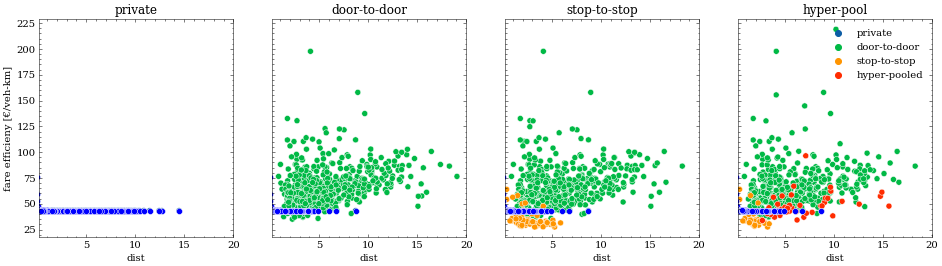

In [48]:
fig, ax = plt.subplots(1,4, figsize = (16,4), sharey = True, sharex= True)
Y = 'fare efficieny [€/veh-km]'
ax = ax.flatten()
titles = ['private','door-to-door','stop-to-stop','hyper-pool']
for level in [0,1,2,3]:
    solution = inData.transitize.rides[inData.transitize.rides['solution_{}'.format(level)] ==1]
    solution['ttrav'] = solution.times.apply(lambda x: sum(x[1:-1]) if len(x)>2 else x[-1])#solution['ttrav_total'] = solution.apply(lambda x: inData.transitize.rm[inData.transitize.rm.ride == x.name].ttrav.sum(),axis = 1)
    solution[Y] = solution['fare'] /solution['ttrav'] * 3600
    solution['dist'] = solution.u_veh/1000*params.avg_speed
    sns.scatterplot(data = solution, x = 'dist', y = Y, hue = 'kind_2' , 
                    ax = ax[level])
    sns.scatterplot(data = solution[solution.kind_2 == 'private'], x = 'dist', y = Y,
                    ax = ax[level], color = 'blue')
    ax[level].set_title(titles[level])
    ax[level].set_xlim(0.2,20)
    if level <3:
        ax[level].get_legend().remove()
plt.savefig('eff.png',dpi = 300)

In [120]:
df = inData.transitize.rm[inData.transitize.rm['solution_{}'.format(3)] ==1]
df['u_private'] = df.apply(lambda x: rm[(rm.traveller == x.traveller) &(rm.kind=='p') ].u.iloc[0], axis =1)
df = df[df.kind=='ms']

In [51]:
225/2000

0.1125

In [43]:
def utility_s2s(traveller):
    # utility of shared trip i for all the travellers
    return (params.price * traveller.fare +
            traveller.VoT * 1.1 * (traveller.ttrav + min(300,traveller.delay)) +
            traveller.VoT * 1 * (traveller.orig_walk_time + traveller.dest_walk_time))

In [122]:
df = inData.transitize.rm[inData.transitize.rm['solution_{}'.format(level)] ==1]
df['u_private'] = df.apply(lambda x: rm[(rm.kind=='p')& (rm.traveller == x.traveller)].u.max(), axis =1)

In [123]:
df['u_n'] = df.apply(lambda x: utility_s2s(x), axis = 1)

In [158]:
mss = rm[(rm.solution_3==1) & (rm.kind == 'ms')]
ms_rides = inData.transitize.rides[(inData.transitize.rides.solution_3==1) & (inData.transitize.rides.kind == 'ms')]
ms_rides

ms_rides['ttrav'] = ms_rides.times.apply(lambda x: sum(x[1:-1]))
ms_rides.ttrav.sum()/3600, mss.ttrav.sum()/3600, mss.ttrav.sum()/ms_rides.ttrav.sum()

(9.762569444444445, 52.495381944444446, 5.3772095802419955)

In [162]:
ms_rides.ttrav.sum()/mss.fare.sum()

72.07557781689663

In [132]:
inData.transitize.rides[mss.ride.unique()

,level_0,index,indexes,indexes_orig,indexes_dest,u_pax,u_veh,kind,ttrav,times,...,orig_walk_time,dest_walk_time,low_level_indexes_set,origin,destination,d2d_reference,solution_2,high_level_indexes,solution_3,fare
0,0,0.0,[0],[0],[0],3.67,214.0,p,214.0,"[0, 214]",...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,2.58
1,1,1.0,[1],[1],[1],0.32,21.0,p,21.0,"[2, 21]",...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,0.25
2,2,2.0,[2],[2],[2],1.37,83.0,p,83.0,"[2, 83]",...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,1.00
3,3,3.0,[3],[3],[3],0.38,25.0,p,25.0,"[2, 25]",...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,0.31
4,4,4.0,[4],[4],[4],23.50,1442.0,p,1442.0,"[4, 1442]",...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,17.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009850,850148,NaN,"[1234, 1022, 1385, 1401, 1266, 1967, 1747, 186...","[160114, 160133, 160119, 159930, 159794, 159929]","[159930, 160133, 160114, 159794, 160119, 159929]",92.27,2891.0,ms,NaN,"[1553.0, 258, 77, 58, 33, 353, 368, 299, 186, ...",...,2730.0,2851.0,NaN,NaN,NaN,NaN,0,"[160114, 160133, 160119, 159930, 159794, 159929]",0,39.11
1009851,850149,NaN,"[1234, 1022, 1385, 1401, 1266, 1967, 1747, 186...","[160114, 160133, 160119, 159930, 160151, 160166]","[159930, 160133, 160114, 160151, 160119, 160166]",91.41,2825.0,ms,NaN,"[1553.0, 258, 77, 58, 33, 353, 368, 299, 186, ...",...,2730.0,2946.0,NaN,NaN,NaN,NaN,0,"[160114, 160133, 160119, 159930, 160151, 160166]",0,39.11
1009852,850150,NaN,"[1234, 1022, 1385, 1401, 1266, 1967, 1747, 186...","[160114, 160133, 160119, 159930, 160151, 159918]","[159930, 160133, 160114, 160151, 160119, 159918]",91.65,2844.0,ms,NaN,"[1553.0, 258, 77, 58, 33, 353, 368, 299, 186, ...",...,2730.0,2948.0,NaN,NaN,NaN,NaN,0,"[160114, 160133, 160119, 159930, 160151, 159918]",0,39.11
1009853,850151,NaN,"[1234, 1022, 1385, 1401, 1266, 1967, 1747, 186...","[160114, 160133, 160119, 159930, 160151, 160177]","[159930, 160133, 160114, 160151, 160119, 160177]",91.65,2844.0,ms,NaN,"[1553.0, 258, 77, 58, 33, 353, 368, 299, 186, ...",...,2730.0,2948.0,NaN,NaN,NaN,NaN,0,"[160114, 160133, 160119, 159930, 160151, 160177]",0,39.11


In [130]:
mss.columns

Index(['ride', 'traveller', 'degree', 'dist', 'ttrav', 'delay', 'u',
       'orig_walk_time', 'dest_walk_time', 'VoT', 'origin', 'destination',
       'treq', 'kind', 's2s_reference', 'door_departure', 'fare', 'solution_0',
       'solution_1', 'solution_2', 'solution_3', 'selected'],
      dtype='object')

In [124]:
df[df.u_n>df.u_private][['u','u_n','u_private', 'delay']]

,u,u_n,u_private,delay
163,4.25,4.33,4.30,10.0
381,8.96,9.40,9.05,14.0
357,8.77,9.21,8.99,15.0
1778,4.08,4.53,4.32,6.0
405,2.14,2.33,2.15,36.0
481,5.22,5.05,4.44,341.0
372,5.11,5.31,5.25,323.0
1399,5.83,5.42,4.87,434.0
1422,4.91,4.70,4.37,412.0
1730,5.14,4.64,3.33,380.5


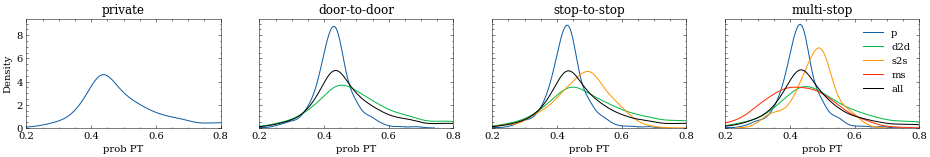

In [48]:
rm = inData.transitize.rm
fig, ax = plt.subplots(1,4, figsize = (16,2), sharey = True, sharex = True)
titles = ['private','door-to-door','stop-to-stop','multi-stop']
for level in [0,1,2,3]:
    df = inData.transitize.rm[inData.transitize.rm['solution_{}'.format(level)] ==1]
    beta = -0.2
    df['prob PT'] = 1-df.apply(lambda x: math.exp(beta*x.u)/
                             (math.exp(beta*x.u)+math.exp(beta*inData.transitize.requests.loc[x.traveller].u_PT)),
                             axis = 1)
    df['logsum'] = df.apply(lambda x:math.log(math.exp(beta*x.u)+
                                              math.exp(beta*inData.transitize.requests.loc[x.traveller].u_PT)) -
                            math.log(math.exp(beta*inData.transitize.requests.loc[x.traveller].u_PT)), axis =1)
    #df['rel']= df.apply(lambda x:(x.u-inData.transitize.requests.loc[x.traveller].u_0)/inData.transitize.requests.loc[x.traveller].u_0, axis =1)
    #df = inData.transitize.requests['u_{}'.format(i)-inData.transitize.requests.u_0
    for kind in df.kind.unique():
        sns.distplot(df[df.kind == kind]['prob PT'],label = kind, ax = ax[level], hist = False)
        #ylim = ax[level].get_ylim()
        #ax[level].plot([df[df.kind == kind]['prob PT'].mean(),df[df.kind == kind]['prob PT'].mean()], (0,5),color = 'black', lw = 3)
        #ax[level].set_ylim(ylim)
    if level>0:
        sns.distplot(df['prob PT'],label = 'all', ax = ax[level], hist = False, color = 'black')
    if level == 3:
        ax[3].legend()
    #if level <3:
    #     ax[level].get_legend().remove()
    ax[level].set_title(titles[level])
    ax[level].set_xlim((0.2,0.8))

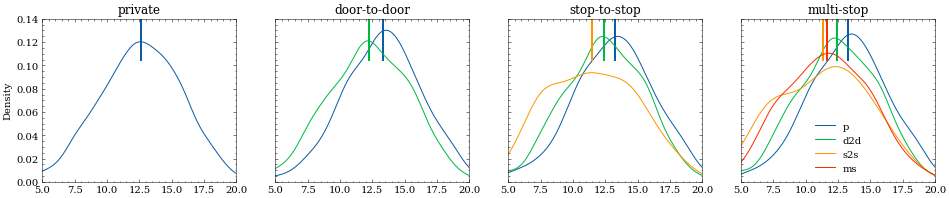

In [104]:
rm = inData.transitize.rm[inData.transitize.rm.selected>0]
fig, ax = plt.subplots(1,4, figsize = (16,3), sharey = True, sharex = True)
ax = ax.flatten()
cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
titles = ['private','door-to-door','stop-to-stop','multi-stop']
for level in [0,1,2,3]:

    solution = rm[rm['solution_{}'.format(level)] ==1].copy()
    #solution[solution.kind == 'ms'].u = solution[solution.kind == 'ms'].apply(lambda x: utility_s2s(x), axis =1) 
    solution['u_private'] = solution.apply(lambda x: rm[(rm.kind=='p')& (rm.traveller == x.traveller)].u.max(), axis =1)
    solution['$\Delta U$'] = np.minimum(0,(solution.u - solution.u_private ) / solution.u)
    for i, kind in enumerate(solution.kind.unique()):
        (solution[solution.kind==kind].VoT*3600).plot.kde(ax=ax[level], label = kind)
        ax[level].axvline((solution[solution.kind==kind].VoT*3600).mean(),0.75,1,lw = 2, color = cmap[i])
    ax[level].set_xlim(5,20)
    ax[level].set_ylim(0,0.140)
    #sns.histplot(data = solution, x = 'VoT', hue = 'kind', ax = ax[level], kde = True, alpha = 0.3, stat = 'percent')
    #sns.scatterplot(data = solution, x = 'VoT', y = '$\Delta U$', hue = 'kind' , 
    #                ax = ax[level])
    # sns.scatterplot(data = solution[solution.kind == 'p'], x = 'VoT', y = '$\Delta U$',
    #                 ax = ax[level], color = 'blue')
    
    ax[level].set_title(titles[level])
    if level ==3:
         ax[level].legend()

In [106]:
rm[(rm['solution_3'] ==1) & rm.kind =='ms']

,ride,traveller,degree,dist,ttrav,delay,u,orig_walk_time,dest_walk_time,VoT,...,treq,kind,s2s_reference,door_departure,fare,solution_0,solution_1,solution_2,solution_3,selected
